In [344]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

np.random.seed(2)

In [345]:
def sigmoid_activation(x):
    # compute the sigmoid activation value for a given input
    return 1.0 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    #compute derivative of sigmoid function
    return x * (1 - x)

def predict(X, W):
    # take the dot product between our features and weight matrix
    preds = sigmoid_activation(X.dot(W))

    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0.5] = 1

    # return the predictions
    return preds

Given a set of input data points X and wights W, we call the sigmoid_activation function on them to obtrain a set of predictions. We then define values <= 0.5 to correspond to class 0 and above to 0.5 to correspond to class 1.

In [346]:
# set parameters
epochs = 100
alpha = 0.01

These two arguments will control our gradient descent function. Epochs is the number of iterations we want to do, alpha is the size of the step we take on each iteration (aka learning rate)

In [347]:
# generate a 2-class classification problem with 1,000 data points,
# where each data point is a 2D feature vector
(X, y) = make_blobs(n_samples=1000, n_features=2, centers=2,
    cluster_std=1.5, random_state=1)
y = y.reshape((y.shape[0], 1))

# insert a column of 1's as the last entry in the feature
# matrix -- this little trick allows us to treat the bias
# as a trainable parameter within the weight matrix
X = np.c_[X, np.ones((X.shape[0]))]

# partition the data into training and testing splits using 50% of
# the data for training and the remaining 50% for testing
(trainX, testX, trainY, testY) = train_test_split(X, y,
    test_size=0.5, random_state=42)

In [348]:
# initialize our weight matrix and list of losses
W = np.random.randn(X.shape[1], 1)
# store a copy so we can use the same initialization values later
W_copy = W.copy()
losses = []

In [349]:
# loop over the desired number of epochs
for epoch in np.arange(0, epochs):
    # take the dot product between our features `X` and the weight
    # matrix `W`, then pass this value through our sigmoid activation
    # function, thereby giving us our predictions on the dataset
    preds = sigmoid_activation(trainX.dot(W))

    # now that we have our predictions, we need to determine the
    # `error`, which is the difference between our predictions and
    # the true values
    error = preds - trainY
    loss = np.sum(error ** 2)
    losses.append(loss)

    # the gradient descent update is the dot product between our
    # features and the error of the sigmoid derivative of our predictions
    d = error * sigmoid_deriv(preds)
    gradient = trainX.T.dot(d)

    # in the update stage, all we need to do is "nudge" the weight
    # matrix in the negative direction of the gradient (hence the
    # term "gradient descent" by taking a small step towards a set
    # of "more optimal" parameters
    W += -alpha * gradient

    # check to see if an update should be displayed
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print("[INFO] epoch={}, loss={:.7f}".format(int(epoch + 1),
            loss))

[INFO] epoch=1, loss=12.7241454
[INFO] epoch=5, loss=0.8898087
[INFO] epoch=10, loss=0.6384174
[INFO] epoch=15, loss=0.5199538
[INFO] epoch=20, loss=0.4454527
[INFO] epoch=25, loss=0.3932711
[INFO] epoch=30, loss=0.3542408
[INFO] epoch=35, loss=0.3237056
[INFO] epoch=40, loss=0.2990215
[INFO] epoch=45, loss=0.2785634
[INFO] epoch=50, loss=0.2612714
[INFO] epoch=55, loss=0.2464217
[INFO] epoch=60, loss=0.2335012
[INFO] epoch=65, loss=0.2221350
[INFO] epoch=70, loss=0.2120420
[INFO] epoch=75, loss=0.2030070
[INFO] epoch=80, loss=0.1948620
[INFO] epoch=85, loss=0.1874739
[INFO] epoch=90, loss=0.1807355
[INFO] epoch=95, loss=0.1745596
[INFO] epoch=100, loss=0.1688743


We iterate until we reach the desired number of epochs, basically allowing the algorithm to view the data 'epoch' number of times.

We use the sigmoid_activation function to predict values. We then calculate the error by subtracting our prediction from the actual truth. We use least squares error over our prediction, which is a simple loss function tipically used on binary classification problems. We append this to the list of losses and use the derivative of the sigmoid activation function to calculate the new weights. We can see the loss function going down on each step.

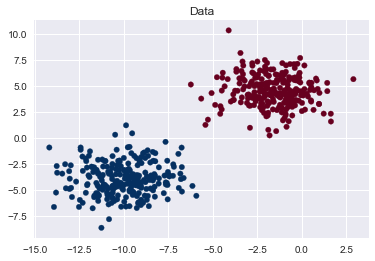

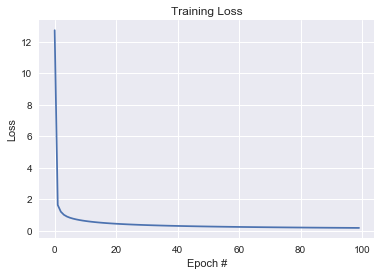

In [350]:
# plot the (testing) classification data
import seaborn as sns
sns.set()

plt.figure()
plt.title("Data")
plt.scatter(testX[:, 0], testX[:, 1], marker="o", c=testY[:, 0], cmap='RdBu', s=30)

# construct a figure that plots the loss over time
plt.figure()
plt.plot(np.arange(0, epochs), losses)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

We can clearly see our data is linear seperable. Our loss also drops dramatically which is expected in such a simple problem.

In [351]:
# evaluate our model
print("[INFO] evaluating...")
preds = predict(testX, W)
print(classification_report(testY, preds))

[INFO] evaluating...
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       250
          1       1.00      1.00      1.00       250

avg / total       1.00      1.00      1.00       500



Notice we got both classes correctly classified 100% of the time, which is a sign that this data is linearly seperable and our gradient descent algorithm was able to descend into an area of low loss, capable of separating the two classes.

However, classical gradient descent might not reach a good value depending on initialization values. To overcome that we need to train with higher epochs and smaller learning rate, which makes it very slow to converge, as weights are updated once per epoch. The next section delas with **Stochastic Gradient Descent (SGD)**, which performs weight updates on every batch of training data, resulting in multiple updates of weight per epoch.

In [352]:
# the only differente is the addition of the next_batch function
def next_batch(X, y, batchSize):
    # loop over our dataset `X` in mini-batches, yielding a tuple of
    # the current batched data and labels
    for i in np.arange(0, X.shape[0], batchSize):
        yield (X[i:i + batchSize], y[i:i + batchSize])

# set a value for batchSize (should be a power of 2)
batchSize = 32

In [353]:
# initialize our weight matrix and list of losses
W = W_copy
sgd_losses = []

# loop over the desired number of epochs
for epoch in np.arange(0, epochs):
    # initialize the total loss for the epoch
    epochLoss = []

    # loop over our data in batches
    for (batchX, batchY) in next_batch(trainX, trainY, batchSize):
        # take the dot product between our current batch of features
        # and the weight matrix, then pass this value through our
        # activation function
        preds = sigmoid_activation(batchX.dot(W))

        # now that we have our predictions, we need to determine the
        # `error`, which is the difference between our predictions
        # and the true values
        error = preds - batchY
        epochLoss.append(np.sum(error ** 2))

        # the gradient descent update is the dot product between our
        # current batch and the error of the sigmoid derivative of our predictions
        d = error * sigmoid_deriv(preds)
        gradient = batchX.T.dot(d)

        # in the update stage, all we need to do is "nudge" the
        # weight matrix in the negative direction of the gradient
        # (hence the term "gradient descent" by taking a small step
        # towards a set of "more optimal" parameters
        W += -alpha * gradient

    # update our loss history by taking the average loss across all
    # batches
    loss = np.average(epochLoss)
    sgd_losses.append(loss)

        # check to see if an update should be displayed
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print("[INFO] epoch={}, loss={:.7f}".format(int(epoch + 1),
            loss))

[INFO] epoch=1, loss=0.4067293
[INFO] epoch=5, loss=0.0854093
[INFO] epoch=10, loss=0.0516504
[INFO] epoch=15, loss=0.0390375
[INFO] epoch=20, loss=0.0321223
[INFO] epoch=25, loss=0.0276497
[INFO] epoch=30, loss=0.0244738
[INFO] epoch=35, loss=0.0220790
[INFO] epoch=40, loss=0.0201955
[INFO] epoch=45, loss=0.0186674
[INFO] epoch=50, loss=0.0173976
[INFO] epoch=55, loss=0.0163224
[INFO] epoch=60, loss=0.0153978
[INFO] epoch=65, loss=0.0145924
[INFO] epoch=70, loss=0.0138833
[INFO] epoch=75, loss=0.0132532
[INFO] epoch=80, loss=0.0126889
[INFO] epoch=85, loss=0.0121800
[INFO] epoch=90, loss=0.0117182
[INFO] epoch=95, loss=0.0112969
[INFO] epoch=100, loss=0.0109107


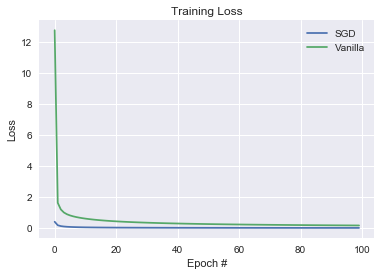

[INFO] evaluating...
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       250
          1       1.00      1.00      1.00       250

avg / total       1.00      1.00      1.00       500



In [354]:
# plot the (testing) classification data
import seaborn as sns
sns.set()

# construct a figure that plots the loss over time
plt.figure()
plt.plot(np.arange(0, epochs), sgd_losses, label='SGD')
plt.plot(np.arange(0, epochs), losses, label='Vanilla')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

# evaluate our model
print("[INFO] evaluating...")
preds = predict(testX, W)
print(classification_report(testY, preds))

Notice that running both gradient descent methods (vanilla vs SGD) with the same data, epochs and learning rate produces the same end result due to the simplicity of data. However, SGD converged much faster and reached a much lower loss value with the same epoch number. This is due to the multiple updates of the weight per epoch, giving our model more chances to learn.